In [5]:
import os
import numpy as np
from matplotlib import pylab as plt

import pandas as pd
import math
import random
from sklearn.metrics import roc_auc_score, f1_score
from functools import reduce

import statistics
from scipy.stats import wilcoxon
plt.rcParams['figure.figsize'] = (8,6)

In [6]:
datapath = "G:\\Dev\\Data"

path = datapath + os.sep + "Convolution vs Dense Experiments"
result_path = datapath + os.sep + "Convolution vs Dense Experiments" # each amino acid has 10 aucs
filtered_dataset_dir = datapath + os.sep + "MSMS-NIST" + os.sep + "Python Filtered"

amino_acid_path = datapath + os.sep + "Fragment Masses.txt"
nist_datapath = datapath + os.sep + "NIST Amino Acids"
nist_baseline_auc_path = datapath + os.sep + "NIST Amino Acids" + os.sep + "NIST Baseline AUC.txt"

In [7]:
def build_training_and_test_set(has_substructure_path):
    substructure = np.loadtxt(has_substructure_path, np.int)
    all_ones = np.where(substructure == 1)
    all_zeros = np.where(substructure == 0)

    number_of_training_set = int(len(all_ones[0]) * 0.7)
    
    training_random_ones = random.sample(list(all_ones[0]), number_of_training_set)
    training_random_zeros = random.sample(list(all_zeros[0]), number_of_training_set)

    test_random_ones = [ones for ones in all_ones[0] if ones not in training_random_ones]
    test_random_zeros = [zeros for zeros in all_zeros[0] if zeros not in training_random_zeros]
    test_random_zeros = random.sample(test_random_zeros, len(test_random_ones))
    
    return training_random_ones, training_random_zeros, test_random_ones, test_random_zeros
    
def get_list_of_ids(dataset):
    return ["GNPS_ALL_" + str(index+1) for index in dataset]

Building training and test dataset

In [8]:
def load_training_spec(spec_path, training_set):
    file_list = os.listdir(spec_path)
    
    filtered_file_list = [file for file in file_list if file[:-13] in training_set]
    filtered_name_list = [filename[:-13] for filename in filtered_file_list]

    intensities = pd.DataFrame(0.0, index = filtered_name_list, columns=range(1000), dtype=float)

    for file in filtered_file_list:
        filepath = os.path.join(spec_path, file)
        mol_name = file[:-13]
        with open(filepath, 'r') as f:
            for index, line in enumerate(f):
                mass, intensity = line.split(" ")
                if not math.isnan(float(intensity)):
                    intensities.at[mol_name, int(mass)-1] = float(intensity)
            
    return intensities

def load_test_spec(spec_path, test_set):
    file_list = os.listdir(spec_path)
    
    filtered_file_list = [file for file in file_list if file[:-13] in test_set]
    filtered_name_list = [filename[:-13] for filename in filtered_file_list]

    test_intensities = pd.DataFrame(0.0, index = filtered_name_list, columns=range(1000), dtype=float)

    for file in filtered_file_list:
        filepath = os.path.join(spec_path, file)
        mol_name = file[:-13]
        with open(filepath, 'r') as f:
            for index, line in enumerate(f):
                mass, intensity = line.split(" ")
                if not math.isnan(float(intensity)):
                    test_intensities.at[mol_name, int(mass)-1] = float(intensity)
            
    return test_intensities

In [9]:
def load_has_substructure(content, intensities):
    has_substructure_truth_values = []
    for index in intensities.index:
        has_substructure_truth_values.append(int(content[int(index.split('_')[2]) - 1][:-1]))
        
    return has_substructure_truth_values

Make a simple keras model to classify this data

In [10]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def baseline_model(input_to_network):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(100,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(50,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

Using TensorFlow backend.


Following model is a convolutional model for this data

In [11]:
def shift_spec_into_tensor(spec_array,shift=[10,20]):
    n_spec,n_bins = spec_array.shape
    spec_tensor = np.zeros((n_spec,n_bins,len(shift)+1),np.double)
    for i in range(n_spec):
        spec = spec_array[i,:]
        shift_spec = np.copy(spec)
        for s in shift:
            shift_spec = np.vstack((shift_spec,np.hstack((spec[s:],np.zeros(s)))))
        spec_tensor[i,:,:] = shift_spec.T
    return spec_tensor[:,:,:,None]

In [12]:
def add_noise(X,n_noise = 5000):
    N,M = X.shape
    for n in range(N):
        X[n,:] += np.random.multinomial(np.random.poisson(n_noise),[1.0/M for m in range(M)])
    return X
def normalise(X):
    for i,row in enumerate(X):
        tot = row.sum()
        if tot > 0:
            for j in range(len(row)):
                X[i,j] = (1.0*row[j])/tot
    return X

- Generate data for the two classes, add some noise and normalise
- Note that `use_shifts` is what the model uses.
- We don't need all the possible shifts to be in `use_shifts` as long as the kernel has sufficient width

In [13]:
from keras.layers import Conv2D,Flatten,MaxPooling2D,AveragePooling2D
def conv_model(n_bins = 1000, n_kernels = 2,kernel_width=1,use_shifts=[15]):
    class_model = Sequential()
    input_shape = (n_bins,len(use_shifts)+1,1)
    n_kernels = n_kernels
    
    pool_width = n_bins - (kernel_width+1)
    pool_size = (pool_width,1)
    
    kernel_size = (kernel_width,len(use_shifts)+1)
    class_model.add(Conv2D(n_kernels, input_shape=input_shape, 
                           kernel_initializer='normal', activation='relu',strides=1,
                          kernel_size = kernel_size))

    class_model.add(MaxPooling2D(pool_size = pool_size))
    class_model.add(Flatten())
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model


Second model for comparison

In [14]:
def calc_peak_differences(spec):
    non_zero_peaks = list(np.where(spec>0)[0])
    peak_differences = [(abs(i-j), (spec[i]+spec[j]/2.0)) for i in non_zero_peaks for j in non_zero_peaks if i != j and j > i]
    
    return peak_differences

In [15]:
def load_shift_bins(intensities):
    shift_bins = np.zeros(intensities.shape, np.double)

    for index, spec in enumerate(intensities.values):
        peak_differences = calc_peak_differences(spec)
        for shift, average_intensity in peak_differences:
            shift_bins[index, shift - 1] += average_intensity

    return shift_bins

In [16]:
def initialise_training_test_set(has_substruct_path):
    training_random_ones, training_random_zeros, test_random_ones, test_random_zeros = build_training_and_test_set(has_substruct_path)
    training_random_ones_id = get_list_of_ids(training_random_ones)
    training_random_zeros_id = get_list_of_ids(training_random_zeros)
    training_set = training_random_ones_id + training_random_zeros_id

    test_random_ones_id = get_list_of_ids(test_random_ones)
    test_random_zeros_id = get_list_of_ids(test_random_zeros)
    test_set = test_random_ones_id + test_random_zeros_id
    return training_set, test_set

def train_conv_diff_splits(path, name, has_substruct_dataset, training_set, test_set, shift, splits=10):
    epochs = 100
    path = path + os.sep + name
    n_kernels = 3
    kernel_width = 5
    truth_values = []
    test_truth_values = []
    aucs = []
    f1_scores = []

    with open(has_substruct_dataset, 'r') as f:
        content = f.readlines()

    for i in range(splits):
        intensities = load_training_spec(filtered_dataset_dir, training_set)
        intensities = intensities.reindex(index=intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

        test_intensities = load_test_spec(filtered_dataset_dir, test_set)
        test_intensities = test_intensities.reindex(index=test_intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

        truth_values = load_has_substructure(content, intensities)
        test_truth_values = load_has_substructure(content, test_intensities)

        X = intensities.values
        N,M = X.shape
        labels = truth_values
        labels = np.array(labels)[:,None]
        test_labels = test_truth_values
        test_labels = np.array(test_labels)[:,None]

        use_shifts = np.asarray([shift])

        X_tensor = shift_spec_into_tensor(X,shift=use_shifts)
        print(X_tensor.shape)

        mod = conv_model(n_kernels = n_kernels, kernel_width=kernel_width, use_shifts=use_shifts)
        mod.fit(X_tensor,labels,epochs=epochs,validation_split=0.2,verbose=0)

        test_tensor = shift_spec_into_tensor(test_intensities.values,shift=use_shifts)
        predicted = mod.predict(test_tensor)
        prediction = np.zeros((predicted.shape))
        prediction[predicted > 0.5] = 1

        auc = roc_auc_score(test_labels, predicted)
        f1 = f1_score(test_labels, prediction)
    
        aucs.append((i, auc))
        f1_scores.append((i, f1))
    
    with open(path + "AUC.txt", 'w') as f:
        for i, auc in aucs:
            f.write(str(auc) + "\n")
    
    with open(path + "F1.txt", 'w') as f:
        for i, f1 in f1_scores:
            f.write(str(f1) + "\n")
        
def train_shifts_diff_splits(path, name, has_substruct_dataset, training_set, test_set, splits=10):
    epochs = 100
    path = path + os.sep + name
    truth_values = []
    test_truth_values = []
    aucs = []
    f1_scores = []
    
    with open(has_substruct_dataset, 'r') as f:
        content = f.readlines()

    for i in range(splits):
        intensities = load_training_spec(filtered_dataset_dir, training_set)
        intensities = intensities.reindex(index=intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

        test_intensities = load_test_spec(filtered_dataset_dir, test_set)
        test_intensities = test_intensities.reindex(index=test_intensities.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

        truth_values = load_has_substructure(content, intensities)
        test_truth_values = load_has_substructure(content, test_intensities)

        X = intensities.values
        N,M = X.shape
        labels = truth_values
        labels = np.array(labels)[:,None]
        test_labels = test_truth_values
        test_labels = np.array(test_labels)[:,None]

        shift_bins = load_shift_bins(intensities)

        X_shifts = normalise(shift_bins)
        print(X_shifts.shape)

        mod = baseline_model(X_shifts)
        mod.fit(X_shifts,labels,epochs=epochs,validation_split=0.2,verbose=0)

        test_shift_bins = load_shift_bins(test_intensities)
        X_test_shifts = normalise(test_shift_bins)
        print(X_test_shifts.shape)

        predicted = mod.predict(X_test_shifts)
        prediction = np.zeros((predicted.shape))
        prediction[predicted > 0.5] = 1

        auc = roc_auc_score(test_labels, predicted)
        f1 = f1_score(test_labels, prediction)
        
        aucs.append((i, auc))
        f1_scores.append((i, f1))
    
    with open(path + "AUC.txt", 'w') as f:
        for i, auc in aucs:
            f.write(str(auc) + "\n")
    
    with open(path + "F1.txt", 'w') as f:
        for i, f1 in f1_scores:
            f.write(str(f1) + "\n")
        

In [17]:
amino_acids_with_shifts = []

with open(amino_acid_path, 'r') as f:
    for line in f:
        amino_acid, shift = line.split(", ")
        amino_acids_with_shifts.append((amino_acid, int(float(shift[:-1]))))

print(amino_acids_with_shifts)

[('Alanine', 71), ('Arginine', 156), ('Asparagine', 114), ('Aspartic Acid', 115), ('Cysteine', 103), ('Glutamic Acid', 129), ('Glutamine', 128), ('Glycine', 57), ('Histidine', 137), ('Isoleucine', 113), ('Leucine', 113), ('Lysine', 128), ('Methionine', 131), ('Phenylalanine', 147), ('Proline', 97), ('Serine', 87), ('Threonine', 101), ('Tryptophan', 186), ('Tyrosine', 163), ('Valine', 99)]


In [13]:
missing_amino_acid = "Glutamine"
processed_amino_acid = []

# might run out of memory at some point, need to keep track of what is processed and reload notebook and rerun this
# processed_amino_acid = ["Alanine", "Arginine", "Asparagine", "Aspartic Acid", "Cysteine", "Glutamic Acid",
#                        "Glycine", "Histidine", "Isoleucine", "Leucine", "Lysine", "Methionine", "Phenylalanine"]

for amino_acid, shift in amino_acids_with_shifts:
    if amino_acid != missing_amino_acid and amino_acid not in processed_amino_acid:
        dataset = datapath + os.sep + "NIST Amino Acids" + os.sep + "NIST {} Has Substructure.txt".format(amino_acid)
        training_set, test_set = initialise_training_test_set(dataset)
        train_shifts_diff_splits(path, "Shifts {} ".format(amino_acid), dataset, training_set, test_set)
        train_conv_diff_splits(path, "Conv {} ".format(amino_acid), dataset, training_set, test_set, shift)

(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000)
(376, 1000)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(872, 1000, 2, 1)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000)
(264, 1000)
(610, 1000, 2, 1)
(610, 1000, 2, 1)
(610, 1000, 2, 1)
(610, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(610, 1000, 2, 1)
(610, 1000, 2, 1)
(610, 1000, 2, 1)
(610, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(610, 1000, 2, 1)
(610, 1000, 2, 1)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000)
(276, 1000)
(644, 1000, 2, 1)
(644, 1000, 2, 1)
(644, 1000, 2, 1)
(644, 1000, 2, 1)
(644, 1000, 2, 1)
(644, 1000, 2, 1)
(644, 1000, 2, 1)
(644, 1000, 2, 1)
(644, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(644, 1000, 2, 1)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000)
(302, 1000)
(702, 1000, 2, 1)
(702, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(702, 1000, 2, 1)
(702, 1000, 2, 1)
(702, 1000, 2, 1)
(702, 1000, 2, 1)
(702, 1000, 2, 1)
(702, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(702, 1000, 2, 1)
(702, 1000, 2, 1)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000)
(314, 1000)
(728, 1000, 2, 1)
(728, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(728, 1000, 2, 1)
(728, 1000, 2, 1)
(728, 1000, 2, 1)
(728, 1000, 2, 1)
(728, 1000, 2, 1)
(728, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(728, 1000, 2, 1)
(728, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000)
(308, 1000)
(716, 1000, 2, 1)
(716, 1000, 2, 1)
(716, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(716, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(716, 1000, 2, 1)
(716, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(716, 1000, 2, 1)
(716, 1000, 2, 1)
(716, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(716, 1000, 2, 1)


C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
def benjamini_fdr(pvalues):
    num_tests = len(pvalues)
    pvalues.sort(key=lambda x: float(x[1])) # Arrange from smallest to highest
    rank = range(1, num_tests+1)
    pvalues_with_rank = [(pvalue[0], pvalue[1], rank[index]) for index, pvalue in enumerate(pvalues)]
    new_values = []
    
    for fingerprint, pvalue, rank in pvalues_with_rank:
        critical_value = (rank / num_tests) * 0.05 # fdr of 0.05 is used
        new_values.append((fingerprint, pvalue, rank, critical_value))
    
        max_pvalue_less_than_crit = 0.0
        max_pvalue_less_than_crit_rank = 0
    
        for fingerprint, pvalue, rank, critical_value in new_values:
            if pvalue > max_pvalue_less_than_crit and pvalue < critical_value:
                max_pvalue_less_than_crit = pvalue
                max_pvalue_less_than_crit_rank = rank
    
    return new_values, max_pvalue_less_than_crit_rank

In [19]:
amino_acid_names = [amino_acid[0] for amino_acid in amino_acids_with_shifts]

#AUC
baseline_aucs = []
mean_shift_aucs = []
mean_conv_aucs = []
shift_stds = []
conv_stds = []
shift_aucs = []
conv_aucs = []

# F1
mean_shift_f1s = []
mean_conv_f1s = []
shift_f1_stds = []
conv_f1_stds = []
shift_f1s = []
conv_f1s = []

with open(nist_baseline_auc_path, 'r') as f:
    for line in f:
        amino_acid, baseline_auc = line.split(",")
        baseline_aucs.append(float(baseline_auc[:-1]))

missing_amino_acid = "Glutamine"
for amino_acid in amino_acid_names:
    if amino_acid != missing_amino_acid:
        amino_acid_shifts_auc_path = os.path.join(result_path, "Shifts {} AUC.txt".format(amino_acid))
        amino_acid_conv_auc_path = os.path.join(result_path, "Conv {} AUC.txt".format(amino_acid))
        amino_acid_shifts_f1_path = os.path.join(result_path, "Shifts {} F1.txt".format(amino_acid))
        amino_acid_conv_f1_path = os.path.join(result_path, "Conv {} F1.txt".format(amino_acid))
        
        with open(amino_acid_shifts_auc_path, 'r') as f:
            numbers = list((float(line[:-1]) for line in f))
            shift_aucs.append(numbers)
            mean_shift_auc = statistics.mean(numbers)
            shift_std = statistics.stdev(numbers)
            mean_shift_aucs.append((amino_acid, mean_shift_auc))
            shift_stds.append((amino_acid, shift_std))
            
        with open(amino_acid_conv_auc_path, 'r') as f:
            numbers = list((float(line[:-1]) for line in f))
            conv_aucs.append(numbers)
            mean_conv_auc = statistics.mean(numbers)
            conv_std = statistics.stdev(numbers)
            mean_conv_aucs.append((amino_acid, mean_conv_auc))
            conv_stds.append((amino_acid, conv_std))

        with open(amino_acid_shifts_f1_path, 'r') as f:
            numbers = list((float(line[:-1]) for line in f))
            shift_f1s.append(numbers)
            mean_shift_f1 = statistics.mean(numbers)
            shift_f1_std = statistics.stdev(numbers)
            mean_shift_f1s.append((amino_acid, mean_shift_f1))
            shift_f1_stds.append((amino_acid, shift_f1_std))
            
        with open(amino_acid_conv_auc_path, 'r') as f:
            numbers = list((float(line[:-1]) for line in f))
            conv_f1s.append(numbers)
            mean_conv_f1 = statistics.mean(numbers)
            conv_f1_std = statistics.stdev(numbers)
            mean_conv_f1s.append((amino_acid, mean_conv_f1))
            conv_f1_stds.append((amino_acid, conv_f1_std))

In [20]:
shift_auc_scores = [aa[1] for aa in mean_shift_aucs]
conv_auc_scores = [aa[1] for aa in mean_conv_aucs]

amino_acid_names_without_glutamine = [name for name in amino_acid_names if name != "Glutamine"]

Trend comparison

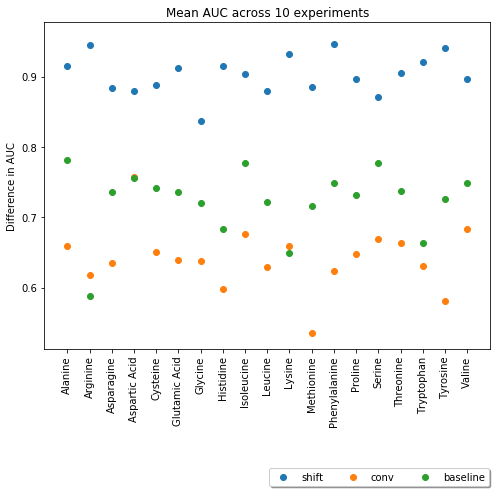

In [21]:
plt.title("Mean AUC across 10 experiments")
plt.scatter(amino_acid_names_without_glutamine, shift_auc_scores, label="shift")
plt.scatter(amino_acid_names_without_glutamine, conv_auc_scores, label="conv")
plt.scatter(amino_acid_names_without_glutamine, baseline_aucs, label="baseline")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, -0.35), shadow=True, ncol=3)
plt.xticks(amino_acid_names_without_glutamine, rotation=90, ha='center')
plt.ylabel("Difference in AUC")
plt.show()

Compare shift against conv

In [22]:
differences = []
z_differences = []
pvalues = []

f1_differences = []
f1_z_differences = []
f1_pvalues = []

for i, amino_acid_auc in enumerate(mean_shift_aucs):
    shift_amino_acid, shift_auc = amino_acid_auc
    conv_amino_acid, conv_auc = mean_conv_aucs[i]
    z_score = float(shift_auc - conv_auc)/(((shift_stds[i][1]**2)+(conv_stds[i][1]**2))**(float(1)/2))
    
    differences.append((shift_amino_acid, shift_auc-conv_auc))
    z_differences.append((shift_amino_acid, z_score))
    
    t_test = wilcoxon(conv_aucs[i], shift_aucs[i])
    pvalues.append((shift_amino_acid, t_test.pvalue))
    
for i, amino_acid_auc in enumerate(mean_shift_f1s):
    shift_amino_acid, shift_f1 = amino_acid_auc
    conv_amino_acid, conv_f1 = mean_conv_f1s[i]
    f1_z_score = float(shift_f1 - conv_f1)/(((shift_f1_stds[i][1]**2)+(conv_f1_stds[i][1]**2))**(float(1)/2))
    
    f1_differences.append((shift_amino_acid, shift_f1-conv_f1))
    f1_z_differences.append((shift_amino_acid, f1_z_score))
    
    t_test = wilcoxon(conv_f1s[i], shift_f1s[i])
    f1_pvalues.append((shift_amino_acid, t_test.pvalue))

In [23]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))
f1_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()
f1_differences.reverse()
f1_z_differences.reverse()

In [24]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_aa = [result[0] for result in stat_significant_results]

In [25]:
amino_acids = [aa[0] + "*" if aa[0] in stat_significant_aa else aa[0] for aa in differences]

z_aa = [aa[0] + "*" if aa[0] in stat_significant_aa else aa[0] for aa in z_differences]

score_differences = [aa[1] for aa in differences]
z_scores = [aa[1] for aa in z_differences]

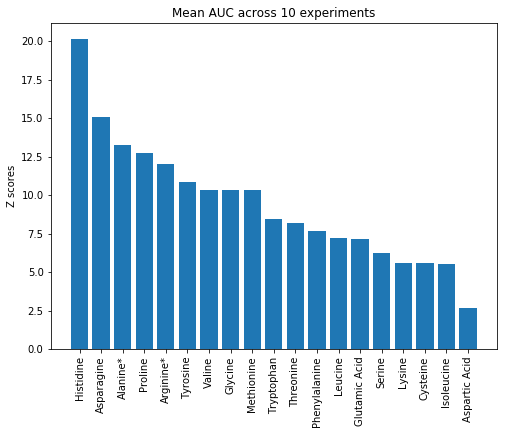

2 significantly different mean aucs
2 significantly positive difference
0 significantly negative difference


In [26]:
error_config = {'ecolor': '0.05'}

plt.title("Mean AUC across 10 experiments")
plt.bar(z_aa, z_scores, align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_aa]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_aa]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))


In [27]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_aa = [result[0] for result in f1_stat_significant_results]

In [28]:
amino_acids = [aa[0] + "*" if aa[0] in f1_stat_significant_aa else aa[0] for aa in f1_differences]

z_aa = [aa[0] + "*" if aa[0] in f1_stat_significant_aa else aa[0] for aa in f1_z_differences]

score_differences = [aa[1] for aa in f1_differences]
z_scores = [aa[1] for aa in f1_z_differences]

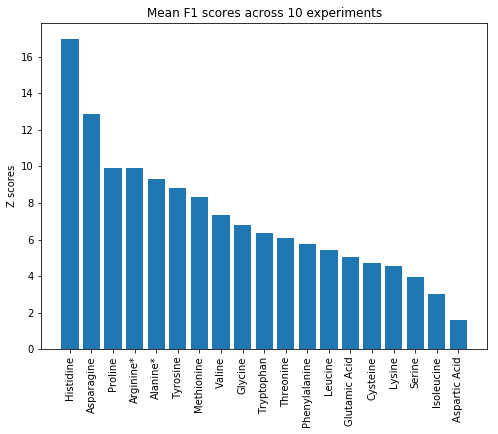

2 significantly different mean f1s
2 significantly positive difference
0 significantly negative difference


In [29]:
error_config = {'ecolor': '0.05'}

plt.title("Mean F1 scores across 10 experiments")
plt.bar(z_aa, z_scores, align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_aa]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_aa]

print("{} significantly different mean f1s".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))
